# Import libraries

In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from PIL import Image
from keras.utils.np_utils import to_categorical

from tensorflow import keras
from keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet201
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.preprocessing.image import ImageDataGenerator

import cv2
from keras.models import load_model
from PIL import Image

# Global Variabel

In [40]:
image_size = (128, 128)
input_shape = (128, 128, 3)
batch_size = 32

# Load DataSet

In [41]:
# Directories
TRAIN_DIR = 'data/fingers/train'
TEST_DIR = 'data/fingers/test'

In [42]:
# Make function to Load Dataset and make labels, the image format (is 0a4d7cbc-2522-4e51-968a-1a86d3b7ee19_5L)
# We only use the count (0, 1, 2, 3, 4, 5), exclude the right or left labels 
def load_images_and_labels(directory):
    images = []
    labels = []
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        img = Image.open(file_path).resize(image_size) #resize the image
        images.append(np.array(img))
        label_part = file.split('_')[1] #extract label from the filename
        label = int(label_part[0])       
        labels.append(label)
    return np.array(images), np.array(labels)

In [43]:
# Load the train and test
X_train, Y_train = load_images_and_labels(TRAIN_DIR)
X_test, Y_test = load_images_and_labels(TEST_DIR)

In [44]:
# Display the image shape, which its still 3D, we need to reshape it to 4D to add 1 channel which represent color
print(f"Train images: {X_train.shape}, Train labels: {Y_train.shape}")
print(f"Test images: {X_test.shape}, Test labels: {Y_test.shape}")

Train images: (18000, 128, 128), Train labels: (18000,)
Test images: (3600, 128, 128), Test labels: (3600,)


In [45]:
# Reshaping the data
X_train = X_train.reshape(18000, 128, 128, 1)
X_test = X_test.reshape(3600, 128, 128, 1)
print(X_train.shape, X_test.shape)

(18000, 128, 128, 1) (3600, 128, 128, 1)


In [46]:
# We do one hot encoding, so the label will print (0, 1, 0, 0, 0, 0) instead of (2)
Y_train = to_categorical(Y_train,6)
Y_test = to_categorical(Y_test, 6)
print(Y_train.shape, Y_test.shape)

(18000, 6) (3600, 6)


In [67]:
# state the data augmentation
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 5%
                               height_shift_range=0.1, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 20% max
                               horizontal_flip=False, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [48]:
# Implement the image data generator
train_image_gen = image_gen.flow(x=X_train,
                                 y=Y_train,
                                 batch_size=batch_size,
                                 shuffle=True)
                
test_image_gen = image_gen.flow(x=X_test,
                                y=Y_test,
                                batch_size=batch_size,
                                shuffle=False)

<h3>Before Data Augmentation</h3>

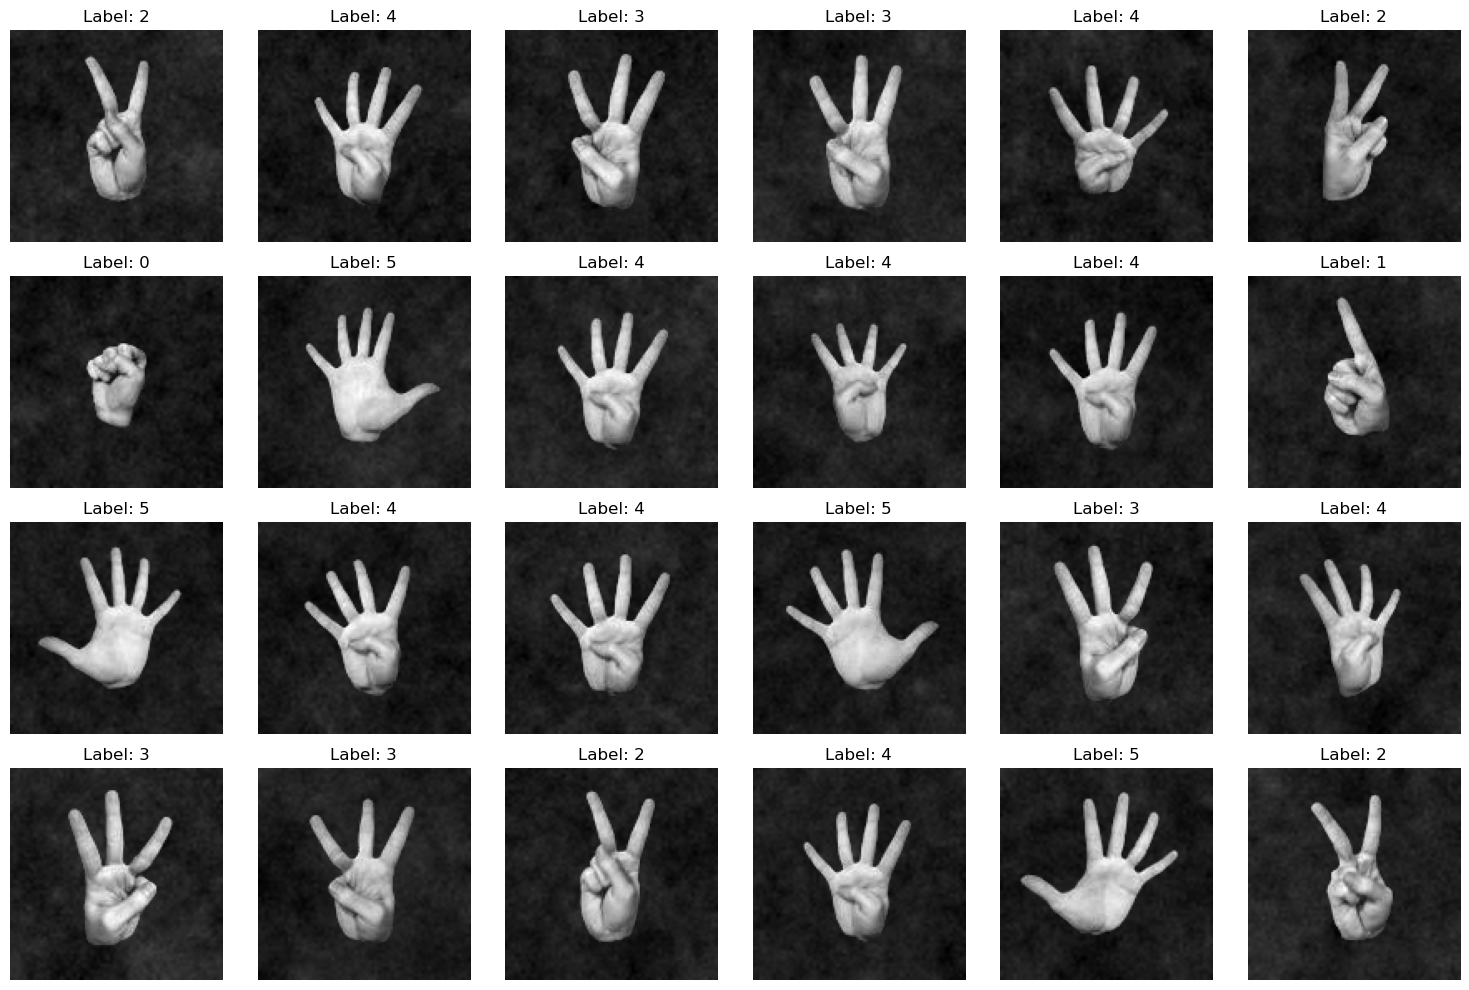

In [86]:
indices = np.arange(len(X_train))
np.random.shuffle(indices)
train_images = X_train[indices]
train_labels = Y_train[indices]

image2 = ImageDataGenerator(rescale=1/255)

# Generate augmented images with shuffling
images = image2.flow(train_images, train_labels, batch_size=1, shuffle=True)

# Display 10 random augmented images with their labels
plt.figure(figsize=(15, 10))
for i in range(24):
    img, aug_label = next(images)  # Get the next random augmented image and label
    img = np.clip(img[0] * 255, 0, 255).astype('uint8')  # Rescale image to 0-255
    aug_label = np.argmax(aug_label[0])  # Decode one-hot encoded label
    
    plt.subplot(4, 6, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {aug_label}")  # Display the label

plt.tight_layout()
plt.show()

<h3>Display the data augmentation</h3>

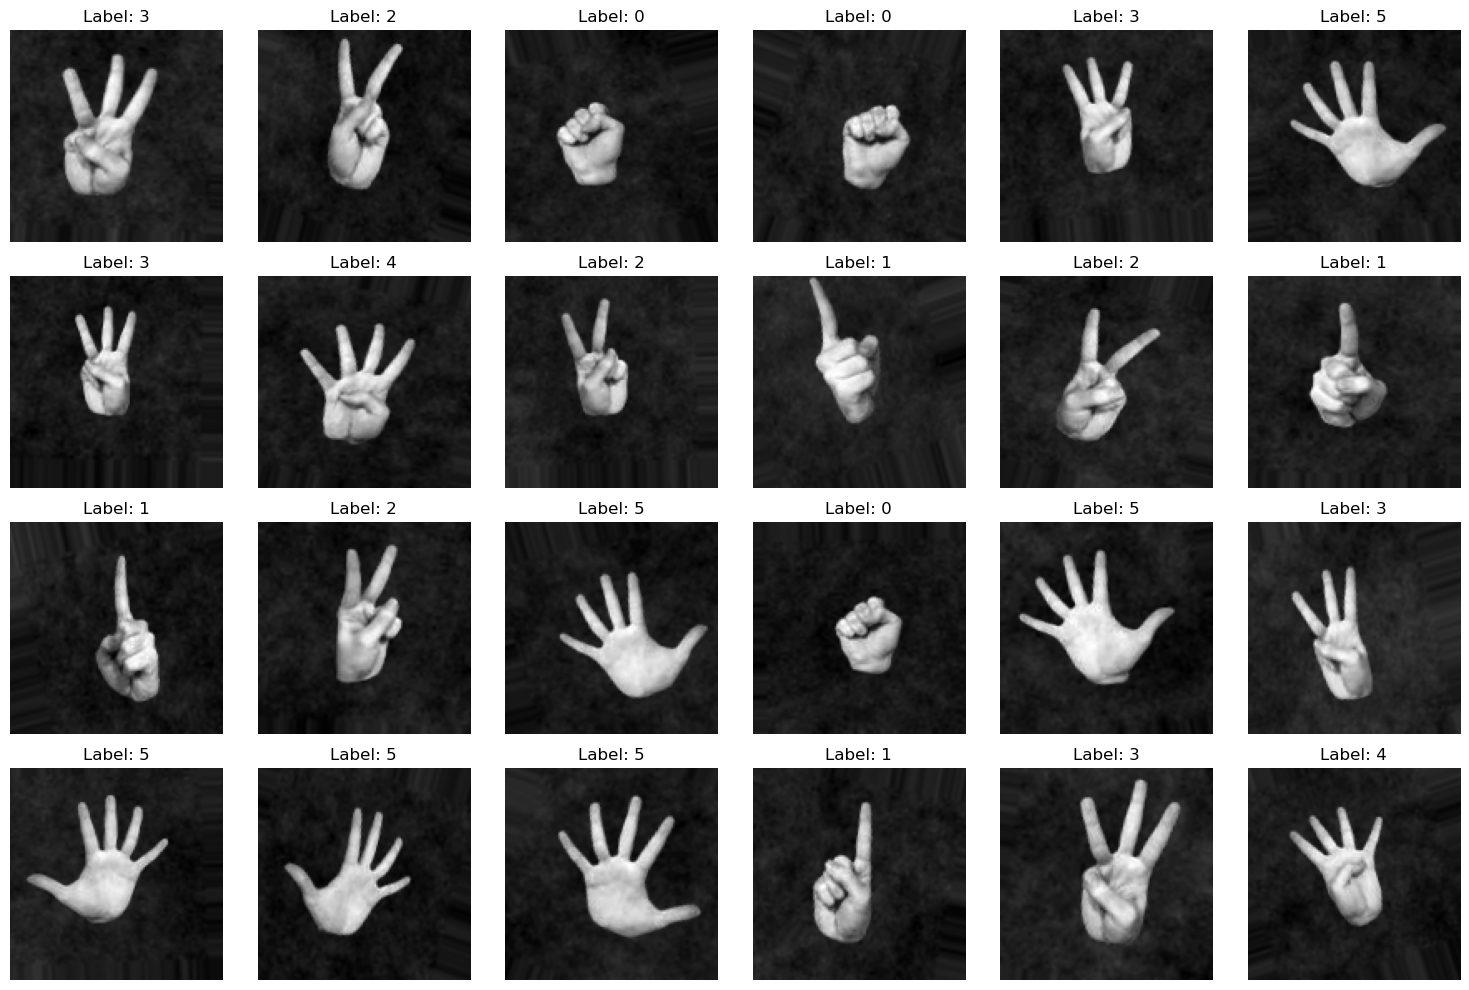

In [81]:
# Assuming train_images and train_labels are NumPy arrays
# Shuffle the dataset
indices = np.arange(len(X_train))
np.random.shuffle(indices)
train_images = X_train[indices]
train_labels = Y_train[indices]

# Generate augmented images with shuffling
augmented_images = image_gen.flow(train_images, train_labels, batch_size=1, shuffle=True)

# Display 10 random augmented images with their labels
plt.figure(figsize=(15, 10))
for i in range(24):
    aug_img, aug_label = next(augmented_images)  # Get the next random augmented image and label
    aug_img = np.clip(aug_img[0] * 255, 0, 255).astype('uint8')  # Rescale image to 0-255
    aug_label = np.argmax(aug_label[0])  # Decode one-hot encoded label
    
    plt.subplot(4, 6, i + 1)
    plt.imshow(aug_img, cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {aug_label}")  # Display the label

plt.tight_layout()
plt.show()

# Build the model

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax') 
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [50]:
history = model.fit(
    train_image_gen,
    epochs=3,
    validation_data=test_image_gen,
    batch_size = batch_size,
    )

Epoch 1/3
563/563 [==============================] - 24s 42ms/step - loss: 0.6439 - accuracy: 0.7467 - val_loss: 0.2813 - val_accuracy: 0.9036
Epoch 2/3
563/563 [==============================] - 23s 41ms/step - loss: 0.1896 - accuracy: 0.9349 - val_loss: 0.1059 - val_accuracy: 0.9678
Epoch 3/3
563/563 [==============================] - 23s 41ms/step - loss: 0.1259 - accuracy: 0.9560 - val_loss: 0.0868 - val_accuracy: 0.9714


In [51]:
model.save("fingers.model")

INFO:tensorflow:Assets written to: fingers.model\assets


In [52]:
pred = model.evaluate(test_image_gen,
                      batch_size = 128)

print("Accuracy of model on test data is: ", pred[1]*100)

113/113 [==============================] - 4s 37ms/step - loss: 0.0919 - accuracy: 0.9694
Accuracy of model on test data is:  96.94444537162781


In [53]:
from sklearn.metrics import classification_report
import numpy as np

# Predict probabilities for the test set
y_pred_probs = model.predict(test_image_gen)  # Shape: (num_samples, num_classes)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(Y_test, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(Y_test.shape[1])])

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       600
           1       0.95      0.99      0.97       600
           2       0.94      0.94      0.94       600
           3       0.96      0.93      0.95       600
           4       0.98      0.96      0.97       600
           5       0.99      0.98      0.99       600

    accuracy                           0.97      3600
   macro avg       0.97      0.97      0.97      3600
weighted avg       0.97      0.97      0.97      3600



# Set up the model to webcam with OpenCV and Pillow

In [54]:
model_ = load_model('fingers.model')

In [55]:
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the resulting frame
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [60]:
video = cv2.VideoCapture(0)

if not video.isOpened():
    raise ValueError("No camera found.")

# Define the rectangle region (x, y, width, height)
rect_x, rect_y, rect_w, rect_h = 330, 50, 200, 200  # Example values, adjust as needed

while True:
    ret, frame = video.read()
    if ret:
        # Draw the rectangle on the frame
        cv2.rectangle(frame, (rect_x, rect_y), (rect_x + rect_w, rect_y + rect_h), (0, 255, 0), 2)

        # Crop the rqectangle region
        cropped_frame = frame[rect_y:rect_y + rect_h, rect_x:rect_x + rect_w]

        # Convert the cropped region to grayscale
        gray_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)

        # Convert the grayscale frame into a PIL Image
        im = Image.fromarray(gray_frame, 'L')

        # Resize to 128x128 (model's input size)
        im = im.resize((128, 128))

        # Convert the image to a numpy array
        img_array = np.array(im)

        # Normalize the image to the range [0, 1]
        img_array = img_array / 255.0

        # Reshape to 4D tensor: (1, height, width, channels)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension

        # Make a prediction using the model
        prediction = model.predict(img_array)  # Prediction will be a vector of probabilities
        predicted_class = np.argmax(prediction)  # Get the index of the highest probability

        # Add the prediction result to the frame
        cv2.putText(
            frame, 
            f"Prediction: {predicted_class}", 
            (rect_x, rect_y - 10),  # Position text above the rectangle
            cv2.FONT_HERSHEY_SIMPLEX, 
            1, 
            (0, 0, 0), 
            2, 
            cv2.LINE_AA
        )

        # Display the frame with prediction
        cv2.imshow("Capturing", frame)

        # Exit loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        raise ValueError("Failed to capture frame.")

# Release resources
video.release()
cv2.destroyAllWindows()